In [2]:
#Librerias necesarias para todo el proyecto
import kagglehub
import hashlib
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Importamos las librerías necesarias para el modelo de CNN
import tensorflow as tf
from tensorflow import keras, config
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Importamos las librerías necesarias para el modelo de Random Forest
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akrashnoor/brain-tumor")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor


In [25]:
# ----------------------------------------------------------------
#  Configuración: rutas y clases
# ----------------------------------------------------------------
# Ruta base del dataset, con subcarpetas por clase (e.g., 'glioma', 'meningioma', etc.)
path_dir = path + '/4 classes'
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
IMAGE_EXT = ('.jpg', '.jpeg', '.png')
semilla = random.seed(123)

# 1.  Exploracion del Dataset (EDA)





## Labels y Numero de imágenes
Dentro del dataset de imágenes podemos encontrar dos directorios destinados a la clasificación biclase y multiclase respectivamente. Nosotros estamos interesandos en el segundo tipo de clasificación por ende llevaremos a cabo exploraciones ahí

In [ ]:
# Mostramos los detalles del directorio
print("Detalles del directorio:")
print(os.listdir(path_dir))

Detalles del directorio:
['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'normal']


In [ ]:
# Diccionario para contar imágenes por subcarpeta
conteo_por_carpeta = {}
total_imagenes = 0

for root, dirs, files in os.walk(path_dir):
    if root == path_dir:
        continue
    carpeta = os.path.basename(root)
    # Filtramos solo archivos de imagen comunes
    imagenes = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    if carpeta not in conteo_por_carpeta:
        conteo_por_carpeta[carpeta] = 0
    conteo_por_carpeta[carpeta] += len(imagenes)
    total_imagenes += len(imagenes)

# Mostramos el conteo por subcarpeta
for carpeta, cantidad in conteo_por_carpeta.items():
    print(f"Carpeta '{carpeta}': {cantidad} imágenes")

print(f"\nTotal de imágenes en todas las subcarpetas: {total_imagenes}")

Carpeta 'pituitary_tumor': 844 imágenes
Carpeta 'meningioma_tumor': 913 imágenes
Carpeta 'glioma_tumor': 901 imágenes
Carpeta 'normal': 438 imágenes

Total de imágenes en todas las subcarpetas: 3096


Podemos notar que efectivamente exiten 4 tipos de clases, las cuales son:
- `normal`, que corresponde al tipo de imágenes del MRI de cerebros sanos y de estas hay 901.
- `glioma, meningioma` y `pituitaria`, que corresponden a las imágenes de cerebros no sanos y en total hay 2195 imágenes de estos tipos.

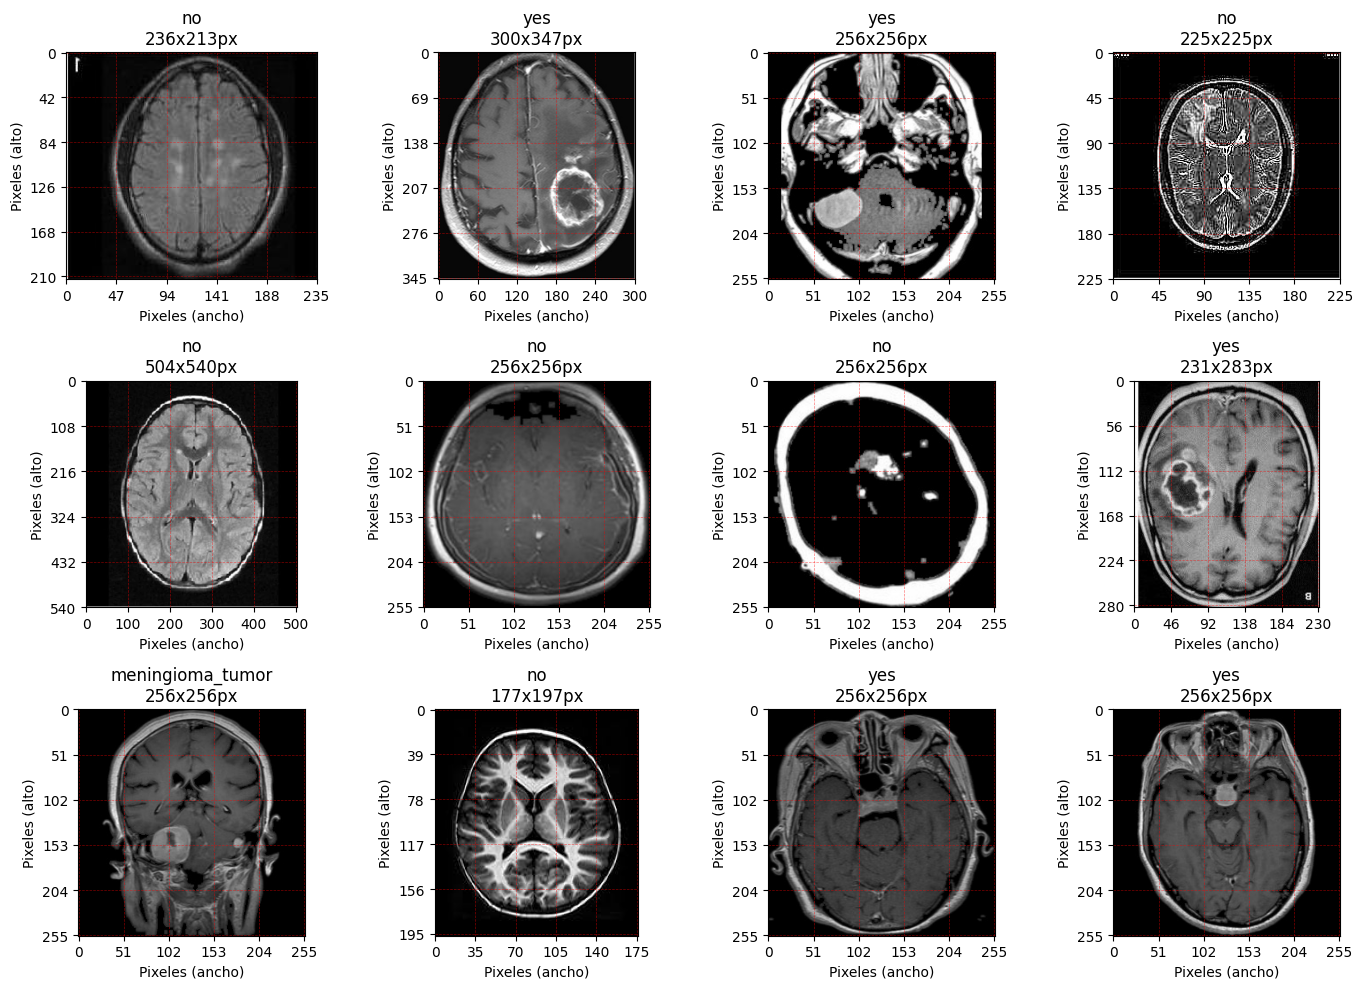

In [ ]:
# Recolectar todas las rutas de imágenes y sus etiquetas (nombre de subcarpeta)
imagenes_info = []
for root, dirs, files in os.walk(path):
    if root == path:
        continue
    etiqueta = os.path.basename(root)
    imagenes = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    for img in imagenes:
        imagenes_info.append((os.path.join(root, img), etiqueta))

# Seleccionar 12 imágenes aleatorias
muestras = random.sample(imagenes_info, 12)

# Cargar imágenes y etiquetas
imagenes_cargadas = []
etiquetas = []
for ruta, etiqueta in muestras:
    try:
        img = Image.open(ruta)
        imagenes_cargadas.append(img)
        etiquetas.append(etiqueta)
    except Exception as e:
        print(f"Error cargando {ruta}: {e}")

# Mostrar en una grilla 3x4 con reglas de tamaño (ejes con ticks)
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i < len(imagenes_cargadas):
        img = imagenes_cargadas[i]
        ancho, alto = img.size
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{etiquetas[i]}\n{ancho}x{alto}px")
        # Mostrar ticks cada 50 pixeles (ajusta según tamaño)
        ax.set_xticks(np.arange(0, ancho+1, max(1, ancho//5)))
        ax.set_yticks(np.arange(0, alto+1, max(1, alto//5)))
        ax.set_xlabel('Pixeles (ancho)')
        ax.set_ylabel('Pixeles (alto)')
        ax.grid(True, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

Si elegimos aleatorioamente algunas imágenes, podemos ver que existen tanto diferencias notables entre los cerebros sanos con los enfermos, entre ellas encontramos la variedad de posiciones de tumor, el ángulo de la cabeza, calidad de la imagen MRI y magnificación de la imagen, lo cual nos da un amplio espectro de análisis.
Aún más importante, podemos notar que todas las imágenes son del mismo tamaño, es decir, $265\times256$. No obstante, es muy luego para afirmar esto.

In [ ]:
# Recolectar todas las rutas de imágenes y sus etiquetas (nombre de subcarpeta)
imagenes_info = []
for root, dirs, files in os.walk(path_dir):
    if root == path_dir:
        continue
    etiqueta = os.path.basename(root)
    imagenes = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    for img in imagenes:
        imagenes_info.append((os.path.join(root, img), etiqueta))

# Seleccionar 100 imágenes aleatorias (puedes ajustar el número)
muestras = random.sample(imagenes_info, min(100, len(imagenes_info)))

# Obtener dimensiones de cada imagen seleccionada
dimensiones = []
for ruta, etiqueta in muestras:
    try:
        with Image.open(ruta) as img:
            ancho, alto = img.size
            dimensiones.append({'archivo': ruta, 'etiqueta': etiqueta, 'ancho': ancho, 'alto': alto})
    except Exception as e:
        print(f"Error cargando {ruta}: {e}")

# Crear un DataFrame para resumir
df_dim = pd.DataFrame(dimensiones)

# Mostrar resumen estadístico de las dimensiones
print("Resumen estadístico de dimensiones de imágenes seleccionadas aleatoriamente:")
print(df_dim[['ancho', 'alto']].describe())

Resumen estadístico de dimensiones de imágenes seleccionadas aleatoriamente:
       ancho   alto
count  100.0  100.0
mean   256.0  256.0
std      0.0    0.0
min    256.0  256.0
25%    256.0  256.0
50%    256.0  256.0
75%    256.0  256.0
max    256.0  256.0


Ahora, tal como se supuso anteriormente, todas las imágenes presentan un mismo tamaño, lo cual es muy bemeficioso para el análisis.
Por otro lado, la distribución de píxeles también juega un rol muy importante al momento de implementar modelos de aprendizaje.

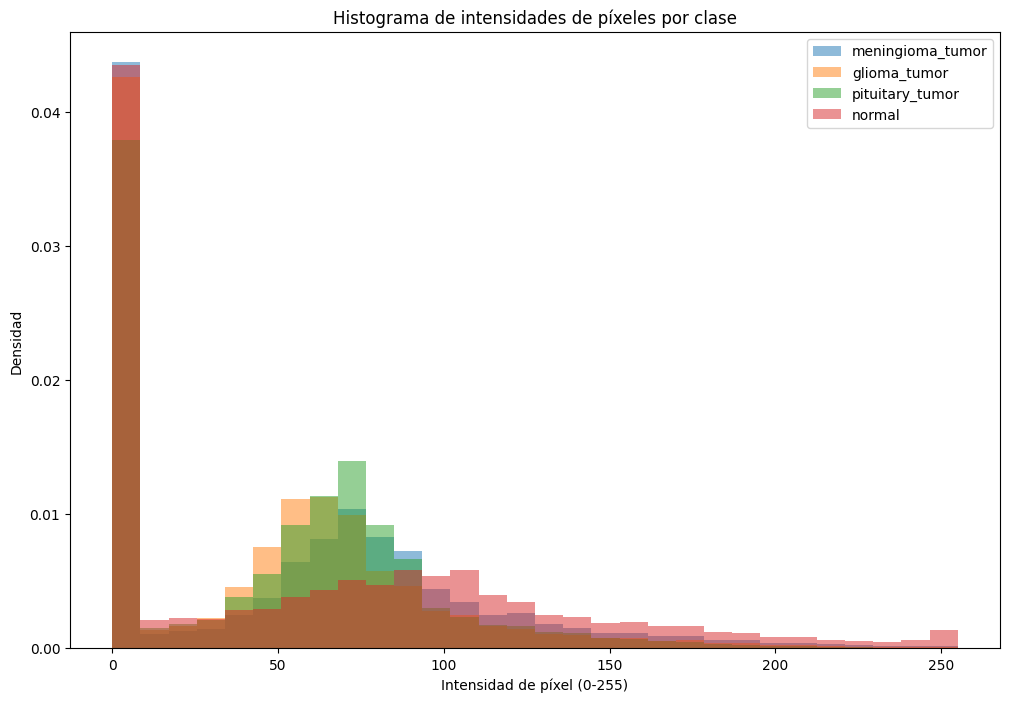

In [ ]:
# Histograma de intensidades de píxeles por clase

# Selecciona una cantidad máxima de imágenes por clase para el histograma (por ejemplo, 50)
max_imgs_por_clase = 50
intensidades_por_clase = {}

for clase in set([etq for _, etq in imagenes_info]):
    rutas_clase = [ruta for ruta, etq in imagenes_info if etq == clase]
    muestras_clase = random.sample(rutas_clase, min(max_imgs_por_clase, len(rutas_clase)))
    intensidades = []
    for ruta in muestras_clase:
        try:
            img = Image.open(ruta)
            img_gray = img.convert('L')  # Convertir a escala de grises
            intensidades.extend(np.array(img_gray).flatten())
        except Exception as e:
            print(f"Error cargando {ruta}: {e}")
    intensidades_por_clase[clase] = intensidades

# Graficar histogramas
plt.figure(figsize=(12, 8))
for clase, intensidades in intensidades_por_clase.items():
    plt.hist(intensidades, bins=30, alpha=0.5, label=clase, density=True)
plt.xlabel('Intensidad de píxel (0-255)')
plt.ylabel('Densidad')
plt.title('Histograma de intensidades de píxeles por clase')
plt.legend()
plt.show()

Este histograma nos dice que en las imágenes MRI de un cerebro sano, la proporción de píxeles se concentra alrededor del *gris claro* (**RGB(100, 100, 100)**) , puesto que la masa cerebral sana presenta mayor contraste con el fondo, esto dado que existen circunvoluciones más diferenciadas.
Por otro lado, los cerebros con tumores relacionados con la *pituitaria* y las células *gliales* presentan una concentración cercana al *gris oscuro* (**RGB(75, 75, 75)**).

Esto nos indica que, al momento de implentar un modelo de clasificación, deberemos centrarnos en determinar la posición aproximada del tumor dependiendo del tipo, un ejemplo de esto, podria se la determinación de los tumores relacionados con la *meninge*, los cuáles se ubican en una zona de alto contraste en la imagen como lo es el extremo de la cabeza y el fondo oscuro.

In [ ]:
imagenes_corruptas = []
hashes = {}
imagenes_duplicadas = []

for ruta, etiqueta in imagenes_info:
    try:
        with Image.open(ruta) as img:
            # Intentar cargar la imagen para detectar corrupción
            img.verify()
        # Calcular hash de la imagen para detectar duplicados
        with open(ruta, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
        if file_hash in hashes:
            imagenes_duplicadas.append((ruta, hashes[file_hash]))
        else:
            hashes[file_hash] = ruta
    except Exception as e:
        imagenes_corruptas.append(ruta)

print(f"Imágenes corruptas detectadas: {len(imagenes_corruptas)}")
for ruta in imagenes_corruptas:
    print(f"Corrupta: {ruta}")

print(f"\nImágenes duplicadas detectadas: {len(imagenes_duplicadas)}")
for dup, orig in imagenes_duplicadas:
    print(f"Duplicada: {dup} <--> Original: {orig}")

Imágenes corruptas detectadas: 0

Imágenes duplicadas detectadas: 251
Duplicada: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_833.jpg <--> Original: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_457.jpg
Duplicada: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_819.jpg <--> Original: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_231.jpg
Duplicada: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_283.jpg <--> Original: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_811.jpg
Duplicada: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_220.jpg <--> Original: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_815.jpg
Duplicada: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_328.jpg <--> Original: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_813.jpg
Duplicada: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_832.jpg <--> Original: /kaggle/input/brain-tumor/4 classes/pituitary_tumor/P_361.jpg
Duplicada: /kaggle/input/brain

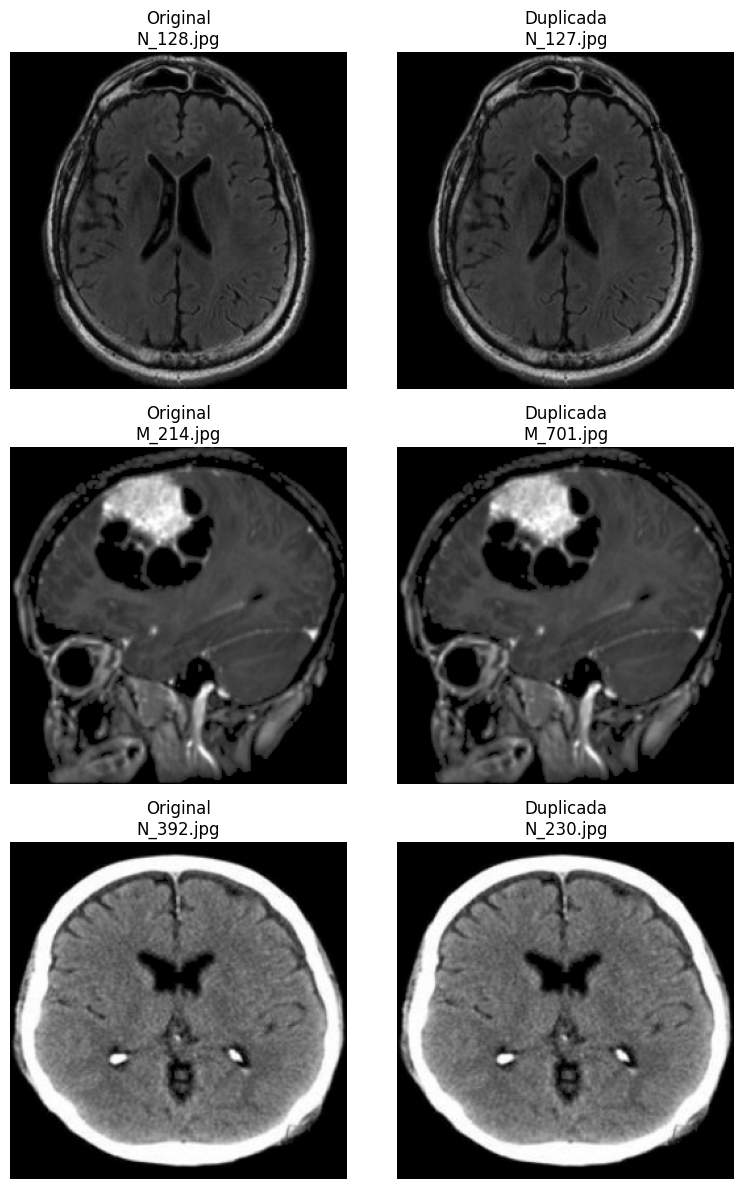

In [ ]:
# Visualizar 3 imágenes duplicadas junto con su imagen original
if len(imagenes_duplicadas) >= 3:
    muestras_duplicadas = random.sample(imagenes_duplicadas, 3)
    fig, axes = plt.subplots(3, 2, figsize=(8, 12))
    for i, (dup_path, orig_path) in enumerate(muestras_duplicadas):
        try:
            img_dup = Image.open(dup_path)
            img_orig = Image.open(orig_path)
            axes[i, 0].imshow(img_orig, cmap='gray')
            axes[i, 0].set_title(f"Original\n{os.path.basename(orig_path)}")
            axes[i, 1].imshow(img_dup, cmap='gray')
            axes[i, 1].set_title(f"Duplicada\n{os.path.basename(dup_path)}")
            for ax in axes[i]:
                ax.axis('off')
        except Exception as e:
            print(f"Error mostrando imágenes: {e}")
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes imágenes duplicadas para mostrar.")

De esto, obtenemos que no existen imágenes corruptas lo que nos simplifica la vida. Sin embargo, existe una proporción mínima de imágenes duplicadas, lo que puede indicar que esto es un error de tipeo al registrar las representaciones o al almacenar los datos. Descartamos un procedimiento de Data Augmentation, debido a que, estas imágenes no presentan rotaciones visibles.


# 2. Limpieza



De lo señalado con anterioridad, hemos encontrado imágenes duplicadas y por ende la limpieza consistirá en eliminar dichas representaciones.

In [ ]:
# # Eliminar imágenes duplicadas, conservando solo una copia de cada una

# eliminadas = []
# for dup_path, orig_path in imagenes_duplicadas:
#     try:
#         os.remove(dup_path)
#         eliminadas.append(dup_path)
#         print(f"Eliminada: {dup_path}")
#     except Exception as e:
#         print(f"Error eliminando {dup_path}: {e}")

# print(f"\nTotal de imágenes duplicadas eliminadas: {len(eliminadas)}")

In [ ]:
# # Obtener la lista de imágenes únicas (sin duplicados)

# imagenes_unicas = set()
# for ruta, etiqueta in imagenes_info:
#     if not any(ruta == dup for dup, _ in imagenes_duplicadas):
#         imagenes_unicas.add((ruta, etiqueta))
#     # Si la imagen es original (no duplicada), también la agregamos
#     for _, orig in imagenes_duplicadas:
#         if ruta == orig:
#             imagenes_unicas.add((ruta, etiqueta))

# imagenes_unicas = list(imagenes_unicas)
# print(f"Total de imágenes únicas (sin duplicados): {len(imagenes_unicas)}")

In [ ]:
# # Obtener solo las etiquetas de las imágenes únicas
# clases = [etiqueta for _, etiqueta in imagenes_unicas]

# # Contar imágenes por clase
# conteo_clases = Counter(clases)

# print("Total de imágenes por clase (sin duplicados):")
# for clase, cantidad in conteo_clases.items():
#     print(f"{clase}: {cantidad}")

Ahora bien, podemos notar lo siguiente:

| Clase      | Imágenes originales | Imágenes sin duplicado | Imágenes eliminadas |
| ---------- | ------------------- | ---------------------- | ------------------- |
| Glioma     | 901                 | 885                    | 16                  |
| Pituitary  | 844                 | 834                    | 10                  |
| Meningioma | 913                 | 816                    | 97                  |
| Normal     | 438                 | 310                    | 128                 |


Sin embargo, luego de trabajar con el proceso correspondiente en cada modelo; hemos considerado que la limpieza es innecesaria. Ahora bien, ¿por qué?; esto se debe a que se pierden muchas imágenes para realizar un análisis exhaustivo, de hecho, al quitar estas representaciones surgen problemas en cuanto al Modelo de CNN debido a la capacidad de entrenamiento y validación para reconocer imágenes sin tumores. Por ende, el estudio previo nos sirvió para reconocer lo que sucede, es por ello que recomendamos comentar el código de limpieza.

#3. Preprocesamiento

Estudiaremos por separado cada procesamiento dependiendo del modelo.
Para el caso de CNN podemos notar que cada imagen es de 256x256 píxeles y trabajaremos con sus tamaño original, también normalizaremos los datos, los aumentaremos de ser necesarios, y en caso de hacerlo, rotaremos las imágenes para aumentar la cantidad de representaciones.
En cuanto a Random Forest llevaremos a cabo un proceso de normalizacion y extraccion de sus caracteristicas.

## 3.1 Modelo de CNN

Consideramos que la cantidad de imágenes es particularmente pequeña para el entrenamiento que queremos realizarle al modelo, es por ello que haremos un *Data Augmentation*.

NOTA:
1. Se recomienda encarecidamente trabajar con un entorno de ejecución de GPU, esto debido a que permitirá una rapidez en el caso de lectura de épocas, sino, tomará más tiempo con el uso de CPU.



In [27]:
# ----------------------------------------------------------------
# Forzar uso de GPU y configurar memoria
# ----------------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Permitir crecimiento de memoria para evitar usar todo el GPU de golpe
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"[INFO] GPUs detectadas: {len(gpus)}, GPUs lógicas: {len(logical_gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("[WARNING] No se detectaron GPUs, entrenando en CPU.")

# ----------------------------------------------------------------

[INFO] GPUs detectadas: 1, GPUs lógicas: 1


2. Por otro lado, el aumento del dataset solo considera un tipo de rotación en las imágenes, debido a que la RAM de colab no soporta más imágenes, es por ello que se decide usar un ángulo de 180 grados. (Puede funcionar con otras rotaciones, lo que lógicamente cambiaría un par de resultados, pero como se indica, sólo debe hacerse con un ángulo para evitar errores.)

In [ ]:
#Data Augmentation
#--------------------------------------------------------------------
# Carpeta raíz que contiene las 4 clases
input_root = path_dir
output_root = 'Tumores_Aumentados'  # Carpeta donde guardar todo

# Crear carpeta raíz de salida si no existe
os.makedirs(output_root, exist_ok=True)

# Ángulos de rotación deseados
angles = [180]

# Recorremos cada subcarpeta (una por clase)
for clase in os.listdir(input_root):
    input_folder = os.path.join(input_root, clase)
    output_folder = os.path.join(output_root, clase)

    if os.path.isdir(input_folder):
        os.makedirs(output_folder, exist_ok=True)

        for filename in os.listdir(input_folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(input_folder, filename)
                img = Image.open(img_path)

                # Guardar imagen original
                img.save(os.path.join(output_folder, filename))

                # Generar imágenes rotadas
                for angle in angles:
                    rotated = img.rotate(angle)
                    name, ext = os.path.splitext(filename)
                    rotated_filename = f"{name}_rot{angle}{ext}"
                    rotated.save(os.path.join(output_folder, rotated_filename))

print("✅ ¡Aumento de datos por rotación completado para las 4 clases!")

✅ ¡Aumento de datos por rotación completado para las 4 clases!


Una vez se realiza el aumento de representaciones y se quiere correr el código de nuevo, se sugiere comentar este código, debido a que la carpeta ya fue creada en colab, y por ende, no es necesario hacerlo nuevamente, a menos, de que exista un reinicio en el entorno.

Ahora bien, debido a que ya realizamos un aumento de datos para el estudio de la CNN, nos toca normalizar las imágenes.


In [ ]:
# Parámetros
target_size_CNN = (256, 256)
grayscale = True
folders = [path_dir, '/content/Tumores_Aumentados']  # ambas carpetas - ojo copiar el path correspondiente
X_CNN = []
y_CNN = []

clases = sorted(os.listdir(folders[0]))   #asumir mismas clases en ambas carpetas

In [ ]:
# Cargar imágenes desde ambas carpetas
for folder in folders:
    for i, clase in enumerate(clases):
        ruta_clase = os.path.join(folder, clase)
        if os.path.isdir(ruta_clase):
            for archivo in os.listdir(ruta_clase):
                if archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                    img_path = os.path.join(ruta_clase, archivo)
                    try:
                        img = load_img(img_path, target_size=target_size_CNN, color_mode='grayscale')
                        img_array = img_to_array(img) / 255.0
                        X_CNN.append(img_array)
                        y_CNN.append(i)
                    except Exception as e:
                        print(f"⚠️ Error cargando {img_path}: {e}")

# Convertir a arrays
X_CNN = np.array(X_CNN)
y_CNN = np.array(y_CNN)

print("✅ Imágenes cargadas:", X_CNN.shape)
print("✅ Etiquetas:", y_CNN.shape)

✅ Imágenes cargadas: (9288, 256, 256, 1)
✅ Etiquetas: (9288,)


Podemos notar que las imágenes han sido normalizadas, y consideradas en escala de grises. Más aún, se puede notar un aumento considerable en la cantidad de representaciones; lo cual nos permitirá que el modelo no tenga un sobreajuste.

## 3.2 Modelado RF con embeddings intermedios de CNN

El Modelo Random Forest Classiffier es un modelo muy capaz para llevar a cabo clasificaciones multiclase y lo suficientemente robusto para sortear imagenes con mucho ruido. Tal como es el caso las imagenes de MRI las cuales poseen ciertos detalles que pueden complicar la tarea, como la existencia de muchas texturas, formas y patrones clinicos.

Por esta razon, realizaremos una implementacion intermedia mediante embeddings CNN preentrenadas, esto pues facilitará mucho la extraccion de *features* en casos como este. Es importante destacar que el uso de esta herramienta se utiliza por la disponibilidad de recursos y no necesariamente por ser optimo

In [43]:
# ----------------------------------------------------------------
# 1. Cargar ResNet50 preentrenada para extracción de embeddings
# ----------------------------------------------------------------
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(256, 256, 3)
)
embedding_model = Model(
    inputs=base_model.input,
    outputs=base_model.output,
    name='resnet50_embedding_extractor')

In [28]:
# ----------------------------------------------------------------
# 2. Función de preprocesamiento para imágenes en escala de grises (MRI)
# ----------------------------------------------------------------
def load_and_prep_grayscale(image_path, target_size=(256, 256)):
    """
    Carga imagen en escala de grises, redimensiona y convierte a 3 canales.
    Devuelve array shape (H, W, 3).
    """
    img = load_img(image_path, target_size=target_size, color_mode='grayscale')
    arr = img_to_array(img)             # (H, W, 1)
    arr = np.repeat(arr, 3, axis=-1)    # (H, W, 3)
    return preprocess_input(arr)

In [29]:
# ----------------------------------------------------------------
# 3. Extracción por lotes nos ayudará a evitar el overhead y
# optimizar el uso de CPU
# ----------------------------------------------------------------
def extract_embeddings(paths, batch_size=32):
    """
    Extrae embeddings para una lista de rutas de imagen usando batch inference.
    Args:
        paths (list of str): Rutas a archivos de imagen.
        batch_size (int): Tamaño de lote.
    Returns:
        np.ndarray: Matriz de embeddings (n_samples, 2048).
    """
    embeddings = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        batch_imgs = np.stack([load_and_prep_grayscale(p) for p in batch_paths])
        embs = embedding_model.predict(batch_imgs, verbose=0)
        embeddings.append(embs)
    return np.vstack(embeddings)

In [30]:
# ----------------------------------------------------------------
# 4. Preparar lista de rutas y etiquetas
# ----------------------------------------------------------------
def gather_paths_labels(dataset_dir, class_names):
    """
    Recorre subcarpetas y devuelve listas de rutas y etiquetas.
    """
    paths, labels = [], []
    for idx, cls in enumerate(class_names):
        cls_folder = os.path.join(dataset_dir, cls)
        for fname in os.listdir(cls_folder):
            if fname.lower().endswith(IMAGE_EXT):
                paths.append(os.path.join(cls_folder, fname))
                labels.append(idx)
    return paths, np.array(labels)

# 4. Implementación del Modelo



## 4.1 Modelo de CNN



In [ ]:
# Parametros
n_clases = 4
input_shape_CNN = (256, 256, 1)

# Codificación one-hot
y_onehot = to_categorical(y_CNN, num_classes=n_clases)

# División entrenamiento/validación
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(
    X_CNN, y_onehot, test_size=0.2, stratify=y_CNN, random_state=42
)

print("✅ X_train:", X_train_CNN.shape)
print("✅ X_val:", X_val_CNN.shape)
print("✅ y_train:", y_train_CNN.shape)
print("✅ y_val:", y_val_CNN.shape)

✅ X_train: (7430, 256, 256, 1)
✅ X_val: (1858, 256, 256, 1)
✅ y_train: (7430, 4)
✅ y_val: (1858, 4)


Podemos notar que el aumento de datos de entrenamiento y de validación corresponden a lo esperado luego de hacer un aumento de representaciones; esto es positivo para el uso del modelo.

Ahora bien, realizaremos la creación del modelo,

In [ ]:
# Definición del modelo
modelo = keras.Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape_CNN),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_clases, activation='softmax')
])

modelo.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[
        'accuracy',
    ]
)

print('Resumen del modelo:')
print(modelo.summary())

Resumen del modelo:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,548 (32.09 MB)

 Trainable params: 8,412,548 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

None


Ahora bien, podemos notar lo siguiente:

| Capa                | Entrada → Salida           | Detalles                                                               |
| -------------------|----------------------------|------------------------------------------------------------------------ |
| **Conv2D(16, 3x3)**| (256×256×1) → (256×256×16) | Padding ‘same’ conserva tamaño. Hay 16 filtros.                         |
| **MaxPooling2D(2x2)**| (256×256×16) → (128×128×16) | Reduce a la mitad cada dimensión.                                      |
| **Conv2D(32, 3x3)**| (128×128×16) → (128×128×32)| 32 filtros, mismo padding.                                              |
| **MaxPooling2D(2x2)**| (128×128×32) → (64×64×32) | Mitad de tamaño.                                                       |
| **Conv2D(64, 3x3)**| (64×64×32) → (64×64×64)    | 64 filtros.                                                            |
| **MaxPooling2D(2x2)**| (64×64×64) → (32×32×64)   | Nuevamente reducción.                                                  |
| **Flatten**        | (32×32×64) → 65536         | 32×32×64 = 65536 neuronas en la capa totalmente conectada.             |
| **Dense(128)**     | 65536 → 128                | Conecta todas las neuronas anteriores a 128 nuevas.                    |
| **Dropout(0.5)**   | 128 → 128                  | Previene overfitting.                                                  |
| **Dense(4)**       | 128 → 4                    | Una neurona por clase, con softmax.                                    |

Y por último, se nos permite notar que el total de parámetros del modelo es de **8,412,548**.


Nuestra siguiente etapa consiste en la ejecución del modelo.

In [ ]:
# Callbacks
os.makedirs('modelos', exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath='modelos/modelo.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

Nota: Son importantes los checkpoints para el desarrollo del modelo, esto debido a que nos va a entregar el mejor resultado.

In [ ]:
# Entrenamiento
n_epocas = 40
print('🔴 Iniciando entrenamiento del modelo...')

historial = modelo.fit(
    X_train_CNN, y_train_CNN,
    validation_data=(X_val_CNN, y_val_CNN),
    epochs=n_epocas,
    batch_size=32,
    shuffle=True,
    callbacks=[checkpoint]
)

print('✅ Entrenamiento finalizado.')

🔴 Iniciando entrenamiento del modelo...
Epoch 1/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3855 - loss: 1.3000 - val_accuracy: 0.6168 - val_loss: 0.9446
Epoch 2/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6040 - loss: 0.9562 - val_accuracy: 0.6884 - val_loss: 0.7615
Epoch 3/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6667 - loss: 0.8007 - val_accuracy: 0.7438 - val_loss: 0.6650
Epoch 4/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7119 - loss: 0.7134 - val_accuracy: 0.7438 - val_loss: 0.6176
Epoch 5/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7455 - loss: 0.6478 - val_accuracy: 0.7723 - val_loss: 0.5676
Epoch 6/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7700 - loss: 0.5854 - val_accuracy: 0.8019 - val_loss: 0.5148
Epoch 7/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7974 - loss: 0.5301 - val_accuracy: 0.8014 - val_loss: 0.4963
Epoch 8/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/ste

Luego de recorrer las épocas del modelo, realizamos un código que nos permita ver el historial que nos muestre la precisión y la pérdida del modelo.

 Historial:
    accuracy      loss  val_accuracy  val_loss
0   0.454374  1.206499      0.616792  0.944612
1   0.624764  0.911361      0.688375  0.761509
2   0.676043  0.787494      0.743811  0.665015
3   0.711709  0.708856      0.743811  0.617601
4   0.752759  0.631769      0.772336  0.567647
5   0.770256  0.580889      0.801938  0.514812
6   0.801077  0.518440      0.801399  0.496335
7   0.810498  0.484778      0.814855  0.451758
8   0.836070  0.428755      0.830463  0.418593
9   0.846299  0.393605      0.869214  0.363285
10  0.862180  0.363116      0.855221  0.382387
11  0.878196  0.330570      0.883208  0.326279
12  0.889098  0.303566      0.884284  0.319092
13  0.897847  0.266848      0.895048  0.287615
14  0.905518  0.255752      0.893434  0.300315
15  0.914670  0.234761      0.902045  0.274377
16  0.912921  0.227008      0.904736  0.273939
17  0.922073  0.205738      0.913886  0.265956
18  0.924092  0.201202      0.915501  0.247887
19  0.929744  0.183986      0.909042  0.242789
2

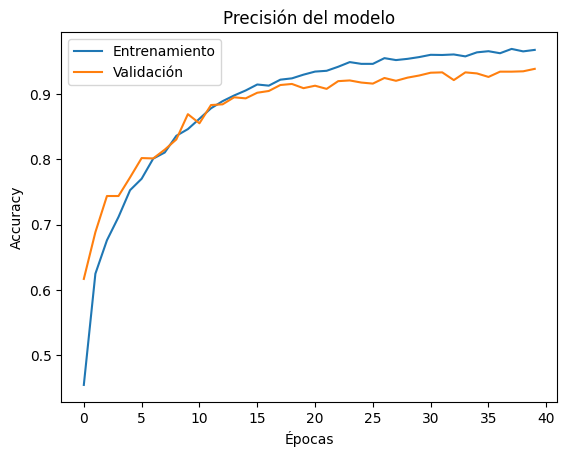

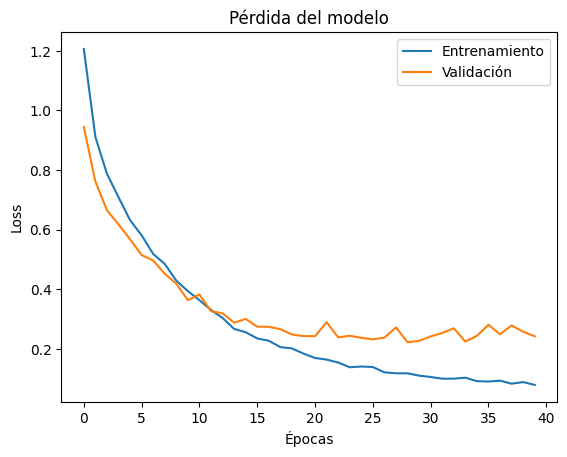

In [ ]:
# Predicción de las clases
print(' Historial:')
print(pd.DataFrame(historial.history))
print(' Graficando historial...')

# Accuracy
plt.plot(historial.history['accuracy'], label='Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(historial.history['loss'], label='Entrenamiento')
plt.plot(historial.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

Podemos notar que a medida que las épocas son más altas, el modelo se va acoplando de mejor forma entre entrenamiento y validación; lo que nos permite suponer que la CNN está realizando un buen trabajo en cuanto a su estudio. De hecho, la precisión es cada vez más alta y la pérdida del modelo más baja.
Además podemos inferir de ambos gráficos que no existe un sobreajuste, por ende, también nos entrega resultados psotivos.

## 4.2 Random Forest con embedding intermedio de cnn


En un inicio, aunque robusto, Random Forest no cumple con las espectativas de clasificacion esperadas para un modelo protenciado en representatividad con CNN. Estos resultado previos son:
### 📊 Reporte de Prueba

| Clase              | Precision | Recall | F1-Score | Soporte |
|--------------------|-----------|--------|----------|---------|
| glioma_tumor       | 0.88      | 0.78   | 0.83     | 181     |
| meningioma_tumor   | 0.74      | 0.77   | 0.75     | 183     |
| normal             | 0.89      | 0.92   | 0.90     | 87      |
| pituitary_tumor    | 0.88      | 0.95   | 0.91     | 169     |
| **Accuracy**       |           |        | **0.84** | 620     |
| **Macro promedio** | 0.85      | 0.85   | 0.85     | 620     |
| **Promedio ponderado** | 0.84  | 0.84   | 0.84     | 620     |

Por esta razon implementamos una busqueda aleatoria de hiperparametros para minimizar el riesgo de overfitting en el tunning mediante CNN, lo cual nos proporcionará una gamma mas amplia de valores con los cuales experimentar en un contexto como el nuestro.

Como comentario adicional, insistimos en el uso de este tipo de busqueda puesto que, aunque 3 clases se clasifican aceptablemente, el modelo aun tiene problemas para clasificar satisfactoriamente los meningiomas.

In [11]:
#----------------------------------------------------------------------
# Esta es la configuracion de los parámetros para la búsqueda aleatoria,
# este procedimiento esta comentado puesto que se lleva a cabo una sola vez
#----------------------------------------------------------------------

# param_dist = {
#     'rf__n_estimators': randint(100, 300),
#     'rf__max_depth': [10, 20, None],
#     'rf__min_samples_split': randint(2, 6),
#     'rf__min_samples_leaf': randint(1, 4),
#     'rf__max_features': ['sqrt', 0.5, 0.8]
# }

# search = RandomizedSearchCV(
#     rf_pipeline,
#     param_distributions=param_dist,
#     n_iter=60,  # más realista
#     cv=3,       # más rápido
#     scoring='f1_weighted',
#     random_state=42,
#     n_jobs=-1,
#     verbose=2
# )

In [41]:
# ----------------------------------------------------------------
# 5. Pipeline Random Forest + escalado + parametros obtenidos con RandomizedSearchCV
# ----------------------------------------------------------------
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators= 170,
        max_depth= None,
        min_samples_split= 2,
        min_samples_leaf= 1,
        max_features= 'sqrt',
        random_state= 42,
        n_jobs= -1
        ))
])


In [42]:
# ----------------------------------------------------------------
# 6. Ejecución principal: split, embeddings, tuning, evaluación
# ----------------------------------------------------------------
if __name__ == '__main__':
    # 6.1 Cargar datos
    paths, labels = gather_paths_labels(path_dir, CLASS_NAMES)

    # 6.2 Split: 60% train, 20% val, 20% test
    p_train, p_temp, y_train, y_temp = train_test_split(
        paths, labels, test_size=0.4, stratify=labels, random_state=42
    )
    p_val, p_test, y_val, y_test = train_test_split(
        p_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    # 6.3 Extraer embeddings
    print('Extracting train embeddings...')
    X_train = extract_embeddings(p_train)
    print('Extracting validation embeddings...')
    X_val   = extract_embeddings(p_val)
    print('Extracting test embeddings...')
    X_test  = extract_embeddings(p_test)

    # 8. Entrenamiento y evaluación
    rf_pipeline.fit(X_train, y_train)
    print("\nValidation Report:")
    yv = rf_pipeline.predict(X_val)
    print(classification_report(y_val, yv, target_names=CLASS_NAMES))

    print("\nTest Report:")
    yt = rf_pipeline.predict(X_test)
    print(classification_report(y_test, yt, target_names=CLASS_NAMES))

    print("\nConfusion Matrix (Test):")
    print(confusion_matrix(y_test, yt))

Extracting train embeddings...
Extracting validation embeddings...
Extracting test embeddings...

Validation Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.75      0.83       180
meningioma_tumor       0.75      0.85      0.79       182
          normal       0.95      0.91      0.93        88
 pituitary_tumor       0.89      0.96      0.92       169

        accuracy                           0.86       619
       macro avg       0.88      0.87      0.87       619
    weighted avg       0.87      0.86      0.86       619


Test Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.73      0.81       181
meningioma_tumor       0.74      0.86      0.80       183
          normal       0.94      0.91      0.92        87
 pituitary_tumor       0.91      0.95      0.93       169

        accuracy                           0.85       620
       macro avg       0.87      0.86      0.87     

Notemos que los resultados entre el modelo con extracción de features mediante CNN con hiperparámetros óptimos y el que no los tenía, no cambia practicamente nada. Esto se puede deber a que el embedding de ResNet50 llevó a cabo un trabajo de extracción notable, tanto que los ajustes finos de los hiperparámetros no tienen un impacto sustancial en los resultados.

# 5. Conclusiones claras y justificadas


## 5.1 Modelo de CNN

Por último, realizamos predicciones del modelo para entender como funciona el Reporte de Clasificación por medio de una matriz de confusión.

In [ ]:
# Obtener predicciones del modelo
y_pred_CNN = modelo.predict(X_val_CNN)
y_pred_CNN = np.argmax(y_pred_CNN, axis=1)
y_true_CNN = np.argmax(y_val_CNN, axis=1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [ ]:
# Reporte detallado por clase
print("Reporte de Clasificación")
print(classification_report(y_true_CNN, y_pred_CNN, target_names=CLASS_NAMES))

Reporte de Clasificación
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.91      0.93       541
meningioma_tumor       0.90      0.92      0.91       548
          normal       0.96      0.94      0.95       263
 pituitary_tumor       0.97      0.99      0.98       506

        accuracy                           0.94      1858
       macro avg       0.94      0.94      0.94      1858
    weighted avg       0.94      0.94      0.94      1858



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


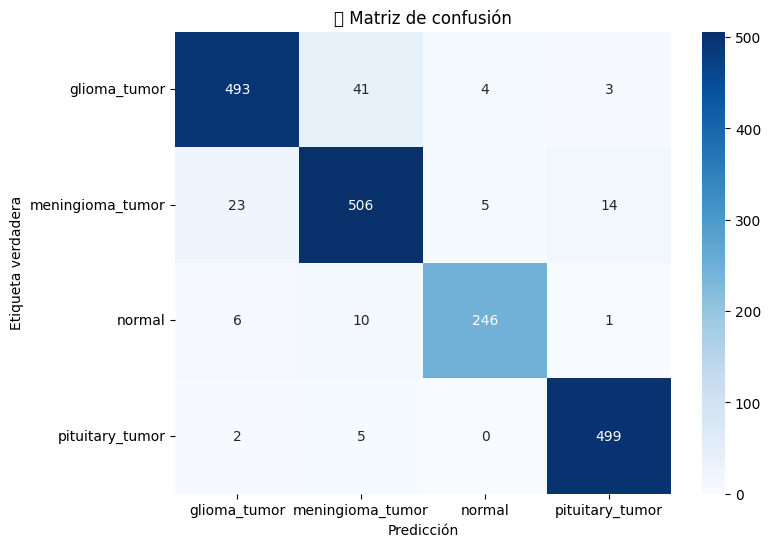

Matriz de Confusión:
[[493  41   4   3]
 [ 23 506   5  14]
 [  6  10 246   1]
 [  2   5   0 499]]


In [ ]:
cm = confusion_matrix(y_true_CNN, y_pred_CNN)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('🔎 Matriz de confusión')
plt.show()

print("Matriz de Confusión:")
print(cm)

Podemos notar que el modelo es bastante acertado, pero podemos notar diversos alcances; entre ellos:
1. Es altamente probable que el tumor Glioma se confunde 41 veces con el tipo Meningioma, esto puede ser debido a la escala de grises de las imágenes por ende el contraste es parecido entre un tumor y otro. Del mismo modo ocurre entre Meningioma y Pituitary en 14 veces, esto se pude deber al mismo motivo anterior; y también por la localización del tumor, esto dado que el de tipo Memingioma surge en los extremos del cerebro, mientras que el de Pituitary (como dice su nombre) en la pituitaria, que igualmente es en una zona extrema.

2. El Reporte de Clasificación nos permite reconcer lo acertado del modelo, alcanzando un promedio del $94\%$, lo que es bastante positivo considerando los bordes del cerebro en cada RX.

3. Por otro lado, la precisión de cada tumor es mayor o igual al $90\%$ lo que indica nuevamente que el modelo de CNN funciona perfectamente.

## 5.2 Modelo RF + embbedings intermedios CNN + LMP

Del punto 4 llegamos a resultados aceptables, pero seguimos teniendo problemas con la clasificacion de la clase de tumor de meninge. Por esta razon, decidimos implementar un ajuste adicional sobre los embeddings para estudiar su impacto y si existe un margen de mejora aun por explorar.

Este ajuste corresponde a un MLP, el cual, al explotar plenamente las estructuras de correlación en el espacio de embeddings, puede conseguir una ganancia significativa en todas las métricas, lo que puede traducirse en mejores resultados de entrenamiento.

In [44]:
 # ----------------------------------------------------------------
# 4. MLP sobre embedding, reduciendo las capas a la mitad
# ----------------------------------------------------------------
def build_mlp(input_dim, num_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [26]:
# ----------------------------------------------------------------
# 4. Ejecución principal: división, extracción, entrenamiento y evaluación
# ----------------------------------------------------------------
# Lo que sigue es una semilla para que los resultados mantengan consistencia
semilla

if __name__ == '__main__':
    # 4.1 Cargar rutas y etiquetas
    paths, labels = gather_paths_labels(path_dir, CLASS_NAMES)

    # 4.2 Dividir: 60% train, 20% val, 20% test (estratificado)
    p_train_rf, p_temp_rf, y_train_rf, y_temp_rf = train_test_split(
        paths, labels, test_size=0.4, stratify=labels, random_state=42
    )
    p_val_rf, p_test_rf, y_val_rf, y_test_rf = train_test_split(
        p_temp_rf, y_temp_rf, test_size=0.5, stratify=y_temp_rf, random_state=42
    )

    # 4.3 Extraer embeddings
    print('Extrayendo embeddings de entrenamiento...')
    X_train_rf = extract_embeddings(p_train_rf)
    print('Extrayendo embeddings de validación...')
    X_val_rf   = extract_embeddings(p_val_rf)
    print('Extrayendo embeddings de prueba...')
    X_test_rf  = extract_embeddings(p_test_rf)

    # 4.4 Convertir etiquetas a categorías para MLP
    y_train_cat = to_categorical(y_train_rf, num_classes=len(CLASS_NAMES))
    y_val_cat   = to_categorical(y_val_rf, num_classes=len(CLASS_NAMES))

    # 4.5 Construir y entrenar el MLP (forzando uso de GPU)
    print('Entrenando MLP sobre embeddings...')
    mlp = build_mlp(input_dim=X_train_rf.shape[1], num_classes=len(CLASS_NAMES))
    mlp.fit(
        X_train_rf, y_train_cat,
        validation_data=(X_val_rf, y_val_cat),
        epochs=30,
        batch_size=32,
        verbose=2
    )

    # 4.6 Evaluación en test
    print('\nEvaluación MLP en test:')
    y_test_cat = to_categorical(y_test_rf, num_classes=len(CLASS_NAMES))
    loss, acc = mlp.evaluate(X_test_rf, y_test_cat, verbose=0)
    print(f"MLP Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")
    y_pred_mlp = np.argmax(mlp.predict(X_test_rf), axis=1)
    print(classification_report(y_test_rf, y_pred_mlp, target_names=CLASS_NAMES))
    print('Matriz de confusión MLP:')
    print(confusion_matrix(y_test_rf, y_pred_mlp))

Extrayendo embeddings de entrenamiento...
Extrayendo embeddings de validación...
Extrayendo embeddings de prueba...
Entrenando MLP sobre embeddings...
Epoch 1/30
59/59 - 4s - 75ms/step - accuracy: 0.4572 - loss: 1.3314 - val_accuracy: 0.7254 - val_loss: 0.7097
Epoch 2/30
59/59 - 2s - 33ms/step - accuracy: 0.6543 - loss: 0.8409 - val_accuracy: 0.7754 - val_loss: 0.5490
Epoch 3/30
59/59 - 0s - 4ms/step - accuracy: 0.7345 - loss: 0.6600 - val_accuracy: 0.8271 - val_loss: 0.4749
Epoch 4/30
59/59 - 0s - 4ms/step - accuracy: 0.7679 - loss: 0.5814 - val_accuracy: 0.8271 - val_loss: 0.4482
Epoch 5/30
59/59 - 0s - 4ms/step - accuracy: 0.8078 - loss: 0.4858 - val_accuracy: 0.8223 - val_loss: 0.3951
Epoch 6/30
59/59 - 0s - 4ms/step - accuracy: 0.8056 - loss: 0.4966 - val_accuracy: 0.8465 - val_loss: 0.4011
Epoch 7/30
59/59 - 0s - 4ms/step - accuracy: 0.7889 - loss: 0.5267 - val_accuracy: 0.8691 - val_loss: 0.3699
Epoch 8/30
59/59 - 0s - 4ms/step - accuracy: 0.8148 - loss: 0.4822 - val_accuracy: 0

Aunque disminuyeron los resultados de clasificación en todas las categorias excepto en la clase meningioma, estos resultados son bastante más satisfactorios que los anteriores, pues existe una consistencia dentro del nivel de clasificación de nuestro modelo.

Esta mejoria en los resultados se debe a:
- MLP captura mejores interacciones, sobretodo las no lineales, lo cual permite la consideración que, de por si, se le escapan a RF
- El ajuste de MLP sobre los embeddings proporciona una optimizacion en los pesos de las clases para maximizar la separación de ellas de forma equitativa y más balanceada.

## 5.3 Conclusión final

Podemos notar que el Modelo de CNN tiene una precisión más alta en comparación al Modelo de Random Forest. Ahora bien, en ambos casos influye el tamaño del dataset, debido a que CNN trabaja con más imágenes en comparación a RF.

Por otro lado, el mayor número de errores de CNN corresponde Glioma y Meningioma; mientras que para RF el mayor número de errores surge en Meningioma y Pituitaria.

Si hablamos ahora de ventajas y limitaciones de cada modelo, tenemos lo siguiente:
1. Modelo de CNN: Identifica patrones complejos, sin embargo, requiere un mayor volumen de datos para entrenar.
2. Modelo de RF + MLP sobre embeddings: Es rápido y ligero para su uso con CPU, sin embargo, depende de la calidad de los embeddings.

Como recomendaciones a futuro en cuanto al trabajo de este dataset, creemos encarecidamente que si se requiere de precisión por sobre el costo computacional, CNN es la mejor opción; mientras que si los recursos son limitados se recomienda el uso de RF+MLP.